In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', '{:.3f}'.format)
import iris
import iris.coord_categorisation
import sys
import time
import datetime
from datetime import datetime
from statsmodels.graphics.mosaicplot import mosaic

sys.path.insert(1, '../Finding_AMAX_Events')
from Identify_Events_Functions import *
from New_Identify_Events_Functions import *

sys.path.insert(1, '../../ProcessEvents')
from Convert_to_Profiles_Functions import *
from Get_Events_Functions import *
from Steef_Functions import *

sys.path.insert(1, '../../AnalyseProfiles')
from Plot_events_functions import *

home_dir = '/nfs/a319/gy17m2a/PhD/'
home_dir2 = '/nfs/a161/gy17m2a/PhD/'

em = 'bb208'
yrs_range= '2060_2081'
sample_cube = iris.load(home_dir + f'datadir/UKCP18_every30mins/2.2km_bng/{yrs_range}/{em}/bng_{em}a.pr206101.nc')[0][1,:,:]
tbo_vals = pd.read_csv(home_dir + 'datadir/RainGauge/interarrival_thresholds_CDD_noMissing.txt')

In [3]:
def calculate_D50(precipitation_values):
    """
    Calculate D50, the point in time when 50% of cumulative precipitation has occurred during an event.
    
    Parameters:
    - precipitation_values: A list or array of precipitation values for a given event.
    
    Returns:
    - D50: The percentage of the event elapsed when 50% of cumulative precipitation has occurred.
    - D50_index: The index where 50% of cumulative precipitation has occurred.
    - cumulative_precip: The cumulative precipitation values for the event.
    """
    # Ensure input is a numpy array
    precipitation_values = np.array(precipitation_values)
    
    # Step 1: Calculate the cumulative precipitation
    cumulative_precip = np.cumsum(precipitation_values)
    
    # Step 2: Determine the total precipitation
    total_precip = cumulative_precip[-1]
    
    # Step 3: Find the index where 50% of the total precipitation is reached
    halfway_precip = total_precip / 2.0
    D50_index = np.where(cumulative_precip >= halfway_precip)[0][0]  # First index where cumulative precipitation >= 50%
    
    # Step 4: Calculate the percentage of the event duration (D50)
    total_timesteps = len(precipitation_values)
    D50 = (D50_index / (total_timesteps - 1)) * 100

    return D50, D50_index, cumulative_precip

def plot_precipitation_with_D50(ax, precipitation_values, D50_index, cumulative_precip, D50):
    """
    Plot the precipitation event and indicate the D50 point on the plot.
    
    Parameters:
    - ax: The axis object to plot the data on.
    - precipitation_values: A list or array of precipitation values for a given event.
    - D50_index: The index where 50% of cumulative precipitation has occurred.
    - cumulative_precip: The cumulative precipitation values for the event.
    - D50: The percentage of the event elapsed when 50% of cumulative precipitation has occurred.
    """
    total_timesteps = len(precipitation_values)

    # Plot precipitation data
    ax.bar(range(total_timesteps), precipitation_values, color='blue', alpha=0.6, label='Precipitation (mm)')
    ax.set_xlabel('Time Step')
    #ax.set_ylabel('Precipitation (mm)', color='blue')
    ax.tick_params(axis='y', labelcolor='blue')

    # Plot cumulative precipitation with a second y-axis
    ax2 = ax.twinx()
    ax2.plot(range(total_timesteps), cumulative_precip, color='green', label='Cumulative Precipitation', lw=2)
    #ax2.set_ylabel('Cumulative Precipitation (mm)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    # Add vertical line for D50
    ax.axvline(D50_index, color='red', linestyle='solid', lw=2, label=f'D50 = {D50:.2f}%')

    # Title and legend
    #ax.set_title('Precipitation Event and D50')
    #ax.legend(loc='upper left')
    #ax2.legend(loc='upper right')

In [4]:
def get_month (df):
    # Step 2: Calculate the median (middle value)
    median_time = df['times'].median()

    # Step 3: Extract the month from the median value
    median_month = median_time.month

    # Convert month number to month name (optional)
    month_name = median_time.strftime('%B')

    return median_month

def create_event_characteristics_dict(this_event):
    
    max_quintile_molly=find_max_quintile(this_event['precipitation (mm)'],5)
    max_third_molly=find_max_quintile(this_event['precipitation (mm)'],3)
    max_quintile_steef=analyse_event(this_event['precipitation (mm)'])[0]
    duration = len(this_event) / 2
    DurationRange_personalised_allems = find_dur_category([1.5, 5.0, 11.5, 22.5, 166.5], ['0.25-2.10 hr', '2.10-6.45 hr', '6.45-19.25 hr', '19.25+ hr'], duration)
    DurationRange_notpersonalised = find_dur_category([0.25, 2.10, 6.45, 19.25, 1000], 
                                                      ['0.25-2.10 hr', '2.10-6.45 hr', '6.45-19.25 hr', '19.25+ hr'], duration)
    return {
        "season" : get_season(this_event['times'][0]),
        'duration':duration,
        "DurationRange_personalised_allems": DurationRange_personalised_allems,
        'DurationRange_notpersonalised':DurationRange_notpersonalised,
        "year":extract_year(this_event),
        "month":get_month(this_event),
        'Volume': sum(this_event['precipitation (mm)'].values),
        'max_intensity': this_event['precipitation (mm)'].max() *2,
        "max_quintile_molly":max_quintile_molly,
        "max_third_molly": max_third_molly,
        'max_quintile_steef' :max_quintile_steef,
        'Loading_profile_molly' :quintile_mapping[max_quintile_molly],
        'Loading_profile_third_molly':quintile_mapping_thirds[max_third_molly],
        'Loading_profile_steef':quintile_mapping[max_quintile_steef],
        'D50_index': calculate_D50(this_event['precipitation (mm)'])[1]
    }


def create_profiles_dict(this_event):
    dimensionless_cumulative_rainfall, dimensionless_cumulative_times = create_huff_curves(this_event['precipitation (mm)'])
    interpolated_cumulative_rainfall, interpolated_times = interpolate_rainfall(dimensionless_cumulative_rainfall,12)
    irain_14vals, irain_times_14vals = create_irain_profile(interpolated_cumulative_rainfall, True)
    irain, irain_times = create_irain_profile(interpolated_cumulative_rainfall, False)
    return {
        "dimensionless_cumulative_rainfall" : dimensionless_cumulative_rainfall,
        'dimensionless_cumulative_times':dimensionless_cumulative_times,
        "interpolated_cumulative_rainfall": interpolated_cumulative_rainfall,
        'interpolated_times':interpolated_times,
        "irain_14vals":irain_14vals,
        'irain_times_14vals': irain_times_14vals,
        "irain":irain,
        "irain_times": irain_times} 

def find_dur_category (bin_edges, duration_labels, duration):
    # Create a pandas Series with the duration
    # Use pd.cut to assign the duration to a bin
    binned_duration = pd.cut(pd.Series([duration]), bins=bin_edges, labels=duration_labels, right=True,  include_lowest=True)
    return binned_duration.iloc[0]

def find_max_quintile (precip, n):
    # Difference with this to Huff curve function, is it doesnt normalise
    cumulative_rainfall, cumulative_rainfall_times = create_cumulative_event(precip)
    dimensionless_cumulative_rainfall, dimensionless_times =  create_dimensionless_event(cumulative_rainfall, cumulative_rainfall_times)
    interpolated_n_cumulative_rainfall, interpolated_n_times = interpolate_rainfall(dimensionless_cumulative_rainfall,n)
    interpolated_n_incremental_rainfall = create_incremental_event(interpolated_n_cumulative_rainfall)
    max_quintile_profile = find_part_with_most_rain(interpolated_n_incremental_rainfall, n)
    
    return max_quintile_profile 


def remove_leading_and_trailing_values(arr, threshold=0.1):
    """
    Remove leading and trailing values less than the threshold from a numpy array.
    
    Parameters:
    - arr: numpy array of precipitation values.
    - threshold: Values below this threshold will be considered for removal at the front and end of the array.
    
    Returns:
    - A numpy array with leading and trailing values less than the threshold removed.
    """
    # Remove leading values below the threshold
    start_idx = 0
    while start_idx < len(arr) and arr[start_idx] < threshold:
        start_idx += 1
    
    # Remove trailing values below the threshold
    end_idx = len(arr)
    while end_idx > start_idx and arr[end_idx - 1] < threshold:
        end_idx -= 1
    
    return arr[start_idx:end_idx]

def calculate_D50(precipitation_values):
    """
    Calculate D50, the point in time when 50% of cumulative precipitation has occurred during an event.
    
    Parameters:
    - precipitation_values: A list or array of precipitation values for a given event.
    
    Returns:
    - D50: The percentage of the event elapsed when 50% of cumulative precipitation has occurred.
    - D50_index: The index where 50% of cumulative precipitation has occurred.
    - cumulative_precip: The cumulative precipitation values for the event.
    """
    # Ensure input is a numpy array
    precipitation_values = np.array(precipitation_values)
    
    # Step 1: Calculate the cumulative precipitation
    cumulative_precip = np.cumsum(precipitation_values)
    
    # Step 2: Determine the total precipitation
    total_precip = cumulative_precip[-1]
    
    # Step 3: Find the index where 50% of the total precipitation is reached
    halfway_precip = total_precip / 2.0
    D50_index = np.where(cumulative_precip >= halfway_precip)[0][0]  # First index where cumulative precipitation >= 50%
    
    # Step 4: Calculate the percentage of the event duration (D50)
    total_timesteps = len(precipitation_values)
    D50 = (D50_index / (total_timesteps - 1)) * 100

    return D50, D50_index, cumulative_precip


In [5]:
quintile_mapping = {1: 'F2', 2: 'F1', 3: 'C', 4: 'B1', 5: 'B2'}
quintile_mapping_thirds = {1: 'F', 2: 'C', 3: 'B'}

## Create one set of events across all gauges

In [ ]:
start_time = time.time()
# all_gauge_top_18_6h_events =[]
for gauge_num in range(446,1293):
    if gauge_num not in [444]:
        print(gauge_num)
        Tb0, idx_2d = find_gauge_Tb0_and_location_in_grid(tbo_vals, gauge_num, sample_cube)
        full_timeslice_cube = iris.load(home_dir + f'datadir/Gauge_Timeslices/2060_2081/{em}/gauge{gauge_num}_farFuture.nc')[0]
        precip_data = full_timeslice_cube.data
        time_coord = full_timeslice_cube.coord('time')
        my_events = my_find_independent_events(precip_data, time_coord, Tb0)
        top_18_6h_events = find_top_n_events_for_duration(my_events, n_events = 18, duration_in_hrs = 6)
        all_gauge_top_18_6h_events.extend(top_18_6h_events)
my_duration = time.time() - start_time
print(f"My code took {my_duration:.4f} seconds.")    

446
447
448
449


In [1]:
# import time
# import concurrent.futures
# import iris  # Assuming iris is already imported

# def process_gauge(gauge_num):
#     if gauge_num not in [444, 827, 888]:
#         print(gauge_num)
#         Tb0, idx_2d = find_gauge_Tb0_and_location_in_grid(tbo_vals, gauge_num, sample_cube)
#         full_timeslice_cube = iris.load(home_dir + f'datadir/Gauge_Timeslices/2060_2081/{em}/gauge{gauge_num}_farFuture.nc')[0]
#         precip_data = full_timeslice_cube.data
#         time_coord = full_timeslice_cube.coord('time')
#         my_events = my_find_independent_events(precip_data, time_coord, Tb0)
#         top_18_6h_events = find_top_n_events_for_duration(my_events, n_events=18, duration_in_hrs=6)
#         return top_18_6h_events
#     return []

# start_time = time.time()
# all_gauge_top_18_6h_events = []

# # Using a ProcessPoolExecutor to parallelize the gauge processing
# with concurrent.futures.ProcessPoolExecutor() as executor:
#     results = list(executor.map(process_gauge, range(0, 1294)))

# # Flatten the results list
# all_gauge_top_18_6h_events = [event for sublist in results for event in sublist]

# my_duration = time.time() - start_time
# print(f"My code took {my_duration:.4f} seconds.")



In [24]:
events_dict={}
event_props_dict={}
event_profiles_dict = {}

for event_num, event in enumerate(all_gauge_top_18_6h_events):
    event_times = event[2]

    event_df = pd.DataFrame({'precipitation (mm)': event[1], 'times': event_times})
    event_props = create_event_characteristics_dict(event_df)
    event_profiles = create_profiles_dict(event_df)
    
    events_dict[event_num]  =event_df
    event_props_dict[event_num] =  event_props
    event_profiles_dict[event_num] = event_profiles

In [25]:
months = [event['month'] for event in event_props_dict.values()]
months_df = pd.DataFrame({'month':months})

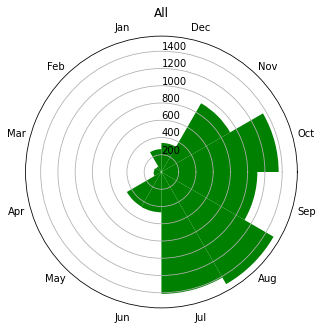

In [26]:
##########################################
####### Circular Histograms ##############
##########################################
N = 12
bottom = 8
max_height = 4

circular_bins = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
circular_bins = np.append(circular_bins, 2 * np.pi)
circular_plot_position = circular_bins + 0.5*np.diff(circular_bins)[0]
circular_plot_position = circular_plot_position[:-1]
circular_plot_position = circular_plot_position + 0.5*np.pi

month_of_event =  np.array(months)

count3 = months_df['month'].value_counts().sort_index()
count3 = count3.reindex(list(range(count3.index.min(),count3.index.max()+1)),fill_value=0)

radii = max_height*np.random.rand(N)
width = (2*np.pi) / N

fig = plt.figure(figsize=(20,5))
ax3 = plt.subplot(111, polar=True)
ax3.bar(circular_plot_position, count3, width=width, bottom=bottom, color="green")

ax3.set_title("All")
ax3.set_rlabel_position(90)
ax3.xaxis.grid(False)
ax3.set_xticks(circular_plot_position - 0.5*np.pi)
ax3.set_xticklabels(['Oct', 'Nov', 'Dec',
                    'Jan', 'Feb', 'Mar', 
                    'Apr', 'May', 'Jun',
                    'Jul', 'Aug', 'Sep',]);

### Process them

In [9]:
profiles = []
for one_dict, the_dict in event_props_dict.items():
    profiles.append(the_dict['Loading_profile_molly'])
profiles_df =pd.DataFrame({"Loading_profile_molly":profiles})

In [13]:
quintile_cats = ['F2','F1', 'C', 'B1', 'B2']
color_mapping = {'F2': (0.0, 0.0, 1.0, 0.6),   'F1': (0.0, 0.6902, 1.0, 0.6),
    'C': (0.5, 0.5, 0.5, 0.6), 'B1': (0.8039, 0.0, 0.0, 0.6),'B2': (0.5451, 0.0, 0.0, 0.6)} 

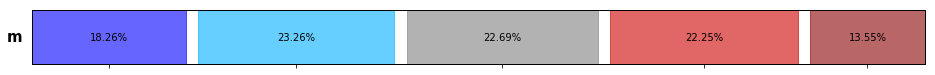

In [14]:
# Create the subplots
fig, axs = plt.subplots(figsize=(16, 1), sharex=True)

create_single_variable_mosaic_plot_pctlabels(axs, profiles_df, 'Loading_profile_molly', 
    quintile_cats, color_mapping, "m")

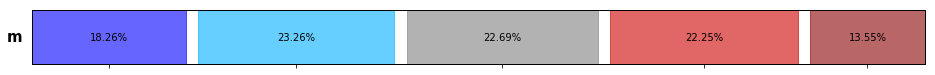

In [15]:
# Create the subplots
fig, axs = plt.subplots(figsize=(16, 1), sharex=True)

create_single_variable_mosaic_plot_pctlabels(axs, profiles_df, 'Loading_profile_molly', 
    quintile_cats, color_mapping, "m")

In [ ]:
# fig, axes = plt.subplots(5, 4, figsize=(24, 16))  # 2x2 grid of subplots
# axes = axes.flatten()  # Flatten the axes array for easy iteration

# # Loop through events and plot each one in its subplot
# for i in range(0,20):
#     this_event = events_dict[i]
#     print(len(this_event))
#     D50, D50_index, cumulative_precip = calculate_D50(this_event['precipitation (mm)'])
#     plot_precipitation_with_D50(axes[i], this_event['precipitation (mm)'], D50_index, cumulative_precip, D50)

# plt.tight_layout()  # Adjust spacing between subplots
# plt.show()

<BarContainer object of 18 artists>

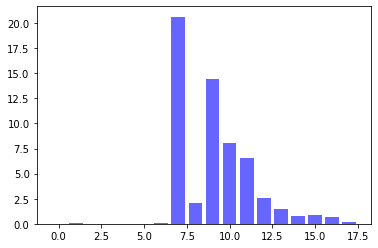

In [116]:
precipitation_values = events_dict[3]['precipitation (mm)']

total_timesteps = len(precipitation_values)

# Plot precipitation data
plt.bar(range(total_timesteps), precipitation_values, color='blue', alpha=0.6, label='Precipitation (mm)')